In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from collections import Counter

In [2]:
np.random.seed(0)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
random_state = 0

In [5]:
df_train = pd.read_csv('dataset_diabetes/diabetic_data_train.csv')

In [6]:
# Removing several medication columns also
remove_cols = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'examide', 
    'citoglipton', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 
    'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone']

In [7]:
df_train = df_train[[col for col in df_train.columns if col not in remove_cols]]

In [8]:
df_train.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

## Create Labels

In [9]:
[(key, val/len(df_train.readmitted)) for (key, val) in Counter(df_train.readmitted).most_common()]

[('NO', 0.5393799439886012),
 ('>30', 0.3491868520611212),
 ('<30', 0.1114332039502776)]

In [10]:
def binarize_readmitted(x):
    if x in ['<30']: # readmitted in less than 30 days is positive class
        return 1 
    else:
        return 0 

In [11]:
df_train['label'] = df_train.apply(lambda x: binarize_readmitted(x['readmitted']), axis=1)

In [12]:
[(key, val/len(df_train.readmitted)) for (key, val) in Counter(df_train['label']).most_common()]

[(0, 0.8885667960497224), (1, 0.1114332039502776)]

## Process Features

In [13]:
def map_age(x):
    if x == '[0-10)':
        return 5
    elif x == '[10-20)':
        return 15
    elif x == '[20-30)':
        return 25
    elif x == '[30-40)':
        return 35
    elif x == '[40-50)':
        return 45
    elif x == '[50-60)':
        return 55
    elif x == '[60-70)':
        return 65
    elif x == '[70-80)':
        return 75
    elif x == '[80-90)':
        return 85
    else:
        return 95

admission_dict = {1: 'Emergency', 2: 'Urgent', 3: 'Elective', 4: 'Newborn', 7: 'Trauma Center'}
def map_admission(x):
    if x in [5,6,8]:
        return 'Not Available'
    elif x == 4:
        return 'Elective'
    else:
        return admission_dict[x]
    
def discharged_home(x):
    if x == 1:
        return 1 # Discharged home
    else:
        return 0 # Other 

def map_source(x):
    if x in [1,2,3]:
        return 'Referral' 
    elif x == 7:
        return 'Emergency Room'
    else:
        return 'Other'

def map_diag(x):
    if x[0].isdigit() == False:
        return 'other'
    
    float_x = float(x)
    if (float_x >= 390 and float_x <= 459) or float_x == 785: # 390–459, 785
        return 'circulatory'
    elif (float_x >= 460 and float_x <= 519) or float_x == 786: # 460–519, 786
        return 'respiratory'
    elif (float_x >= 520 and float_x <= 579) or float_x == 787: # 520–579, 787
        return 'digestive'
    elif float_x >= 250 and float_x < 251: # 250.xx
        return 'diabetes'
    elif float_x >= 800 and float_x <= 999: # 800–999
        return 'injury'
    elif float_x >= 710 and float_x <= 739: # 710–739
        return 'musculoskeletal'
    elif (float_x >= 580 and float_x <= 629) or float_x == 788: # 580–629, 788
        return 'genitourinary'
    elif float_x >= 140 and float_x <= 239: # 140–239
        return 'neoplasms'
    else:
        return 'other'

def binarize_yn(x):
    if x in ['Yes', 'Ch']: 
        return 1 
    else:
        return 0 

In [14]:
df_train['age_processed'] = df_train.apply(lambda x: map_age(x['age']), axis=1)
df_train['admission_type_processed'] = df_train.apply(lambda x: map_admission(x['admission_type_id']), axis=1)
df_train['discharged_processed'] = df_train.apply(lambda x: discharged_home(x['discharge_disposition_id']), axis=1)
df_train['source_processed'] = df_train.apply(lambda x: map_source(x['admission_source_id']), axis=1)

In [15]:
df_train['diag1_processed'] = df_train.apply(lambda x: map_diag(x['diag_1']), axis=1)
df_train['diag2_processed'] = df_train.apply(lambda x: map_diag(x['diag_2']), axis=1)
df_train['diag3_processed'] = df_train.apply(lambda x: map_diag(x['diag_3']), axis=1)
df_train['change_processed'] = df_train.apply(lambda x: binarize_yn(x['change']), axis=1)
df_train['diabetesMed_processed'] = df_train.apply(lambda x: binarize_yn(x['diabetesMed']), axis=1)

## One Hot Encodings

In [16]:
ohe_cols = ['admission_type_processed', 'source_processed',
    'diag1_processed', 'diag2_processed', 'diag3_processed', 'race', 'gender', 
    'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 
    'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']

In [17]:
# Remove 2 rows where gender is invalid (probably doesn't matter but just incase)
df_train = df_train[df_train.gender != 'Unknown/Invalid']
print(len(df_train))

81410


In [18]:
df_train_sub = df_train[ohe_cols]

In [19]:
ohe = OneHotEncoder(categories='auto')
train_ohe = ohe.fit_transform(df_train_sub).toarray()

In [20]:
# obtain column names for one hot encoded columns 
feature_labels = []
feature_labels_ = ohe.categories_
for col, values in zip(df_train_sub.columns, feature_labels_):
    for val in values:
        feature_labels.append(col+'_'+val)

In [21]:
df_train_ohe = pd.DataFrame(train_ohe, columns = feature_labels)

In [22]:
num_cols = ['age_processed', 'discharged_processed', 'change_processed', 'diabetesMed_processed', 
        'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
        'number_outpatient','number_emergency', 'number_inpatient', 'number_diagnoses']

df_train_num = df_train[num_cols]

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_num_scaled = scaler.fit_transform(df_train_num.astype(np.float64))

In [24]:
df_train_num = pd.DataFrame(df_train_num_scaled, index=df_train_num.index, columns=df_train_num.columns)

In [25]:
print(df_train_ohe.shape, df_train_num.shape)

(81410, 87) (81410, 12)


In [26]:
# Reindexing because df_train_ohe has different indices than df_train_num (due to removing the two invalid gender entries)
# and not doing this will create null entries when concatenating 
df_train_ohe.reset_index(drop=True, inplace=True)
df_train_num.reset_index(drop=True, inplace=True)

In [27]:
X_train = pd.concat([df_train_ohe, df_train_num], axis=1)

In [28]:
for col in X_train.columns:
    print(col)
    print(Counter(X_train[col]), '\n')

admission_type_processed_Elective
Counter({0.0: 66348, 1.0: 15062}) 

admission_type_processed_Emergency
Counter({1.0: 43216, 0.0: 38194}) 

admission_type_processed_Not Available
Counter({0.0: 73136, 1.0: 8274}) 

admission_type_processed_Trauma Center
Counter({0.0: 81397, 1.0: 13}) 

admission_type_processed_Urgent
Counter({0.0: 66565, 1.0: 14845}) 

source_processed_Emergency Room
Counter({1.0: 45988, 0.0: 35422}) 

source_processed_Other
Counter({0.0: 70656, 1.0: 10754}) 

source_processed_Referral
Counter({0.0: 56742, 1.0: 24668}) 

diag1_processed_circulatory
Counter({0.0: 56981, 1.0: 24429}) 

diag1_processed_diabetes
Counter({0.0: 74423, 1.0: 6987}) 

diag1_processed_digestive
Counter({0.0: 73861, 1.0: 7549}) 

diag1_processed_genitourinary
Counter({0.0: 77288, 1.0: 4122}) 

diag1_processed_injury
Counter({0.0: 75921, 1.0: 5489}) 

diag1_processed_musculoskeletal
Counter({0.0: 77481, 1.0: 3929}) 

diag1_processed_neoplasms
Counter({0.0: 78671, 1.0: 2739}) 

diag1_processed_othe

In [29]:
y_train = df_train['label'].values

In [30]:
from sklearn.neural_network import MLPClassifier

## Cross Validation Pipeline

In [31]:
pipe = Pipeline([
        ('sampling', SMOTE(random_state=random_state)),
        ('model', MLPClassifier(random_state=random_state))
    ])

pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sampling', 'model', 'sampling__k_neighbors', 'sampling__n_jobs', 'sampling__random_state', 'sampling__sampling_strategy', 'model__activation', 'model__alpha', 'model__batch_size', 'model__beta_1', 'model__beta_2', 'model__early_stopping', 'model__epsilon', 'model__hidden_layer_sizes', 'model__learning_rate', 'model__learning_rate_init', 'model__max_fun', 'model__max_iter', 'model__momentum', 'model__n_iter_no_change', 'model__nesterovs_momentum', 'model__power_t', 'model__random_state', 'model__shuffle', 'model__solver', 'model__tol', 'model__validation_fraction', 'model__verbose', 'model__warm_start'])

In [32]:
# from sklearn.metrics import precision_recall_curve

In [33]:
param_grid={
'model__learning_rate': ["constant"],
'model__hidden_layer_sizes': [(30, 10), (20, 20, 20), (20, 20, 15)],
'model__alpha': [.015], #between .01 and .5 is best. .1 seemed best after trying .01 to 1, started getting worse at .5 
'model__activation': ["relu"]
}

# Recall = TP/TP+FN -> Of the ones that are positive, how many did we indicate as positive
# AUROC = area under curve TPR (TP/TP+FN) vs. FPR (FP/TN+FP) at various thresholds
scoring = ['balanced_accuracy', 'accuracy', 'roc_auc', 'recall', 'precision']

In [34]:
clf = GridSearchCV(pipe, param_grid, cv=3, verbose=5, scoring=scoring, refit='roc_auc', return_train_score=True)

In [35]:
best_model = clf.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(30, 10), model__learning_rate=constant 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(30, 10), model__learning_rate=constant, accuracy=(train=0.836, test=0.802), balanced_accuracy=(train=0.625, test=0.543), precision=(train=0.300, test=0.175), recall=(train=0.353, test=0.209), roc_auc=(train=0.738, test=0.587), total= 2.8min
[CV] model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(30, 10), model__learning_rate=constant 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
/Users/kalyaniasthana/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(30, 10), model__learning_rate=constant, accuracy=(train=0.858, test=0.828), balanced_accuracy=(train=0.589, test=0.522), precision=(train=0.320, test=0.161), recall=(train=0.244, test=0.129), roc_auc=(train=0.734, test=0.565), total= 2.9min
[CV] model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(30, 10), model__learning_rate=constant 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s
/Users/kalyaniasthana/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(30, 10), model__learning_rate=constant, accuracy=(train=0.860, test=0.823), balanced_accuracy=(train=0.602, test=0.529), precision=(train=0.338, test=0.169), recall=(train=0.270, test=0.150), roc_auc=(train=0.740, test=0.575), total= 2.8min
[CV] model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 20), model__learning_rate=constant 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.6min remaining:    0.0s
/Users/kalyaniasthana/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 20), model__learning_rate=constant, accuracy=(train=0.853, test=0.833), balanced_accuracy=(train=0.583, test=0.536), precision=(train=0.299, test=0.190), recall=(train=0.235, test=0.154), roc_auc=(train=0.709, test=0.590), total= 3.3min
[CV] model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 20), model__learning_rate=constant 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.9min remaining:    0.0s


[CV]  model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 20), model__learning_rate=constant, accuracy=(train=0.830, test=0.803), balanced_accuracy=(train=0.599, test=0.539), precision=(train=0.267, test=0.171), recall=(train=0.301, test=0.200), roc_auc=(train=0.704, test=0.577), total= 2.5min
[CV] model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 20), model__learning_rate=constant 
[CV]  model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 20), model__learning_rate=constant, accuracy=(train=0.851, test=0.828), balanced_accuracy=(train=0.582, test=0.534), precision=(train=0.290, test=0.183), recall=(train=0.236, test=0.155), roc_auc=(train=0.708, test=0.583), total= 2.1min
[CV] model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 15), model__learning_rate=constant 
[CV]  model__activation=relu, model__alpha=0.015, model__hidden_layer_sizes=(20, 20, 15), model__learning_rate=const

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 22.5min finished
/Users/kalyaniasthana/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [36]:
best_model.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=0)),
                ('model',
                 MLPClassifier(alpha=0.015, hidden_layer_sizes=(20, 20, 15),
                               random_state=0))])

In [37]:
best_model.cv_results_

{'mean_fit_time': array([171.69406239, 158.16684031, 119.45026509]),
 'std_fit_time': array([ 3.41153642, 30.44400394, 23.61567787]),
 'mean_score_time': array([0.12947702, 0.18916742, 0.12085907]),
 'std_score_time': array([0.0121719 , 0.0241942 , 0.00377016]),
 'param_model__activation': masked_array(data=['relu', 'relu', 'relu'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__alpha': masked_array(data=[0.015, 0.015, 0.015],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__hidden_layer_sizes': masked_array(data=[(30, 10), (20, 20, 20), (20, 20, 15)],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__learning_rate': masked_array(data=['constant', 'constant', 'constant'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__activation': 'relu',
  

In [38]:
df_test = pd.read_csv('dataset_diabetes/diabetic_data_test.csv')

In [39]:
df_test = df_test[[col for col in df_test.columns if col not in remove_cols]]

In [40]:
df_test['label'] = df_test.apply(lambda x: binarize_readmitted(x['readmitted']), axis=1)

In [41]:
[(key, val/len(df_test.readmitted)) for (key, val) in Counter(df_test.readmitted).most_common()]

[('NO', 0.5380760538469097),
 ('>30', 0.34966100029478236),
 ('<30', 0.11226294585830796)]

In [42]:
[(key, val/len(df_test.readmitted)) for (key, val) in Counter(df_test['label']).most_common()]

[(0, 0.887737054141692), (1, 0.11226294585830796)]

In [43]:
df_test['age_processed'] = df_test.apply(lambda x: map_age(x['age']), axis=1)
df_test['admission_type_processed'] = df_test.apply(lambda x: map_admission(x['admission_type_id']), axis=1)
df_test['discharged_processed'] = df_test.apply(lambda x: discharged_home(x['discharge_disposition_id']), axis=1)
df_test['source_processed'] = df_test.apply(lambda x: map_source(x['admission_source_id']), axis=1)

In [44]:
df_test['diag1_processed'] = df_test.apply(lambda x: map_diag(x['diag_1']), axis=1)
df_test['diag2_processed'] = df_test.apply(lambda x: map_diag(x['diag_2']), axis=1)
df_test['diag3_processed'] = df_test.apply(lambda x: map_diag(x['diag_3']), axis=1)
df_test['change_processed'] = df_test.apply(lambda x: binarize_yn(x['change']), axis=1)
df_test['diabetesMed_processed'] = df_test.apply(lambda x: binarize_yn(x['diabetesMed']), axis=1)

In [45]:
df_test = df_test[df_test.gender != 'Unknown/Invalid']
print(len(df_test))

20353


In [46]:
df_test_sub = df_test[ohe_cols]

In [47]:
test_ohe = ohe.fit_transform(df_test_sub).toarray()

In [48]:
# obtain column names for one hot encoded columns 
feature_labels = []
feature_labels_ = ohe.categories_
for col, values in zip(df_test_sub.columns, feature_labels_):
    for val in values:
        feature_labels.append(col+'_'+val)

In [49]:
df_test_ohe = pd.DataFrame(test_ohe, columns = feature_labels)

In [50]:
df_test_num = df_test[num_cols]

In [51]:
df_test_num_scaled = scaler.fit_transform(df_test_num.astype(np.float64))

In [52]:
df_test_num = pd.DataFrame(df_test_num_scaled, index=df_test_num.index, columns=df_test_num.columns)

In [53]:
print(df_test_ohe.shape, df_test_num.shape)

(20353, 87) (20353, 12)


In [54]:
print(df_train_ohe.shape, df_train_num.shape)

(81410, 87) (81410, 12)


In [55]:
df_test.shape

(20353, 41)

In [56]:
df_train.shape

(81410, 41)

In [57]:
final_clf = best_model.best_estimator_

In [58]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, recall_score, precision_score
from sklearn.metrics import roc_auc_score

In [59]:
# X_test = pd.concat([df_test_ohe, df_test_num], axis=1)

In [60]:
# y_test = df_test['label'].values

In [61]:
# X_test.head()

In [62]:
df_test_ohe.reset_index(drop=True, inplace=True)
df_test_num.reset_index(drop=True, inplace=True)

In [63]:
X_test = pd.concat([df_test_ohe, df_test_num], axis=1)

In [64]:
y_test = df_test['label'].values

In [65]:
y_test_pred = final_clf.predict(X_test)

NameError: name 'precisions' is not defined

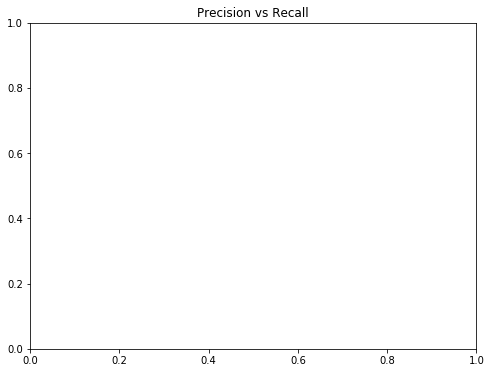

In [67]:
def plot_precision_vs_recall(precision, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
#     plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plt.title('Precision vs Recall')
plot_precision_vs_recall(precisions, recalls)
# plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
# plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
# plt.plot([recall_90_precision], [0.9], "ro")
# save_fig("precision_vs_recall_plot")
# plt.show()

In [78]:
from sklearn.metrics import roc_curve

In [79]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

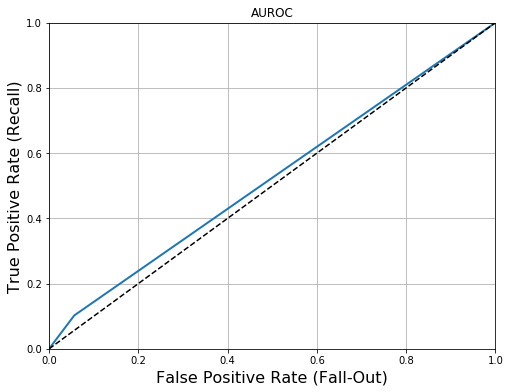

In [84]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                  # Not shown
plt.title('AUROC')
# plt.legend(loc='upper left')
plot_roc_curve(fpr, tpr)
# fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
# plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
# plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
# plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
# save_fig("roc_curve_plot")                                    # Not shown
# plt.show()

In [85]:
roc_auc_score(y_test, y_test_pred)

0.5229491287230491

In [86]:
accuracy_score(y_test, y_test_pred)

0.8490640200461849

In [87]:
balanced_accuracy_score(y_test, y_test_pred)

0.5229491287230492

In [88]:
precision_score(y_test, y_test_pred)

0.18645418326693228

In [89]:
recall_score(y_test, y_test_pred)

0.10240700218818381